# Tässä on siis kaksi viimeisintä mallia

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Authenticated
Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Tarkista käytettävissä olevat GPU-laitteet
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("CUDA is available")
    print("Number of GPUs:", len(gpus))
    print("GPU details:", gpus)
else:
    print("No CUDA device found")


No CUDA device found


# Datan haku BQ:stä

# Oma myyntidata

In [ ]:
%%bigquery df --project touhua-001

SELECT date, ROUND(SUM(amount), 1) AS amount
FROM touhua-001.fazer.stg_sryhma_account_sales_by_ean_last
WHERE date BETWEEN '2023-09-01' AND '2024-06-29'
GROUP BY date




Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
own = df

In [ ]:

own

,date,amount
0,2024-02-02,833702.9
1,2024-02-26,617316.8
2,2023-10-14,655088.1
3,2024-01-22,646784.5
4,2023-09-21,669605.0
...,...,...
298,2024-01-06,568267.9
299,2023-12-27,545769.4
300,2024-04-28,474306.0
301,2023-10-19,660309.6


# MUUT

In [ ]:
%%bigquery df --project touhua-001
SELECT
    SALES_DATE as date,
    ROUND(SUM(SALES_AMOUNT), 1) as amount
FROM
    `touhua-001.fazer.stg_sryhma_competitor_sales_last`
      WHERE SALES_DATE BETWEEN '2023-09-01' AND '2024-02-29'
GROUP BY
    SALES_DATE



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
comp = df
comp

,date,amount
0,2024-02-10,2752720.5
1,2024-02-07,2562835.7
2,2023-12-29,2782353.6
3,2023-11-02,2836623.0
4,2023-11-01,2576908.5
...,...,...
177,2023-10-28,2412101.8
178,2023-11-21,2372601.6
179,2023-11-25,2396325.6
180,2023-10-15,1715659.2


In [ ]:
# prompt: full join own and comp on date = date

import pandas as pd
result = pd.merge(own, comp, on='date', how='outer')
result


,date,amount_x,amount_y
0,2024-02-02,833702.9,3294126.3
1,2024-02-26,617316.8,2438124.9
2,2023-10-14,655088.1,2408088.5
3,2024-01-22,646784.5,2441807.3
4,2023-09-21,669605.0,2627468.4
...,...,...,...
298,2024-01-06,568267.9,2026865.6
299,2023-12-27,545769.4,2177722.1
300,2024-04-28,474306.0,NaN
301,2023-10-19,660309.6,2603431.3


In [ ]:
# prompt: rename amount_x as amount_own and amount_y as amount_comp

result = result.rename(columns={'amount_x': 'amount_own', 'amount_y': 'amount_comp'})
result


,date,amount_own,amount_comp
0,2024-02-02,833702.9,3294126.3
1,2024-02-26,617316.8,2438124.9
2,2023-10-14,655088.1,2408088.5
3,2024-01-22,646784.5,2441807.3
4,2023-09-21,669605.0,2627468.4
...,...,...,...
298,2024-01-06,568267.9,2026865.6
299,2023-12-27,545769.4,2177722.1
300,2024-04-28,474306.0,NaN
301,2023-10-19,660309.6,2603431.3


In [ ]:
# prompt: make new column "amount_comp_final" where (amount_comp - amount_own) if amount_comp value is NaN then return NaN

import pandas as pd
result['amount_comp_final'] = result.apply(lambda row: (row['amount_comp'] - row['amount_own']) if pd.notna(row['amount_comp']) else None, axis=1)
result


,date,amount_own,amount_comp,amount_comp_final
0,2024-02-02,833702.9,3294126.3,2460423.4
1,2024-02-26,617316.8,2438124.9,1820808.1
2,2023-10-14,655088.1,2408088.5,1753000.4
3,2024-01-22,646784.5,2441807.3,1795022.8
4,2023-09-21,669605.0,2627468.4,1957863.4
...,...,...,...,...
298,2024-01-06,568267.9,2026865.6,1458597.7
299,2023-12-27,545769.4,2177722.1,1631952.7
300,2024-04-28,474306.0,NaN,NaN
301,2023-10-19,660309.6,2603431.3,1943121.7


In [ ]:
# prompt: drop amount_comp column and then rename amount_comp_final as amount_comp

result = result.drop('amount_comp', axis=1)
result = result.rename(columns={'amount_comp_final': 'amount_comp'})
combined_df = result


In [ ]:
combined_df = result
combined_df

,date,amount_own,amount_comp
0,2024-02-02,833702.9,2460423.4
1,2024-02-26,617316.8,1820808.1
2,2023-10-14,655088.1,1753000.4
3,2024-01-22,646784.5,1795022.8
4,2023-09-21,669605.0,1957863.4
...,...,...,...
298,2024-01-06,568267.9,1458597.7
299,2023-12-27,545769.4,1631952.7
300,2024-04-28,474306.0,NaN
301,2023-10-19,660309.6,1943121.7


# TEST

In [ ]:
combined_df


,date,amount_own,amount_comp
0,2024-02-02,833702.9,2460423.4
1,2024-02-26,617316.8,1820808.1
2,2023-10-14,655088.1,1753000.4
3,2024-01-22,646784.5,1795022.8
4,2023-09-21,669605.0,1957863.4
...,...,...,...
298,2024-01-06,568267.9,1458597.7
299,2023-12-27,545769.4,1631952.7
300,2024-04-28,474306.0,NaN
301,2023-10-19,660309.6,1943121.7


<ipython-input-79-334267557eda>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 448789.0471403317


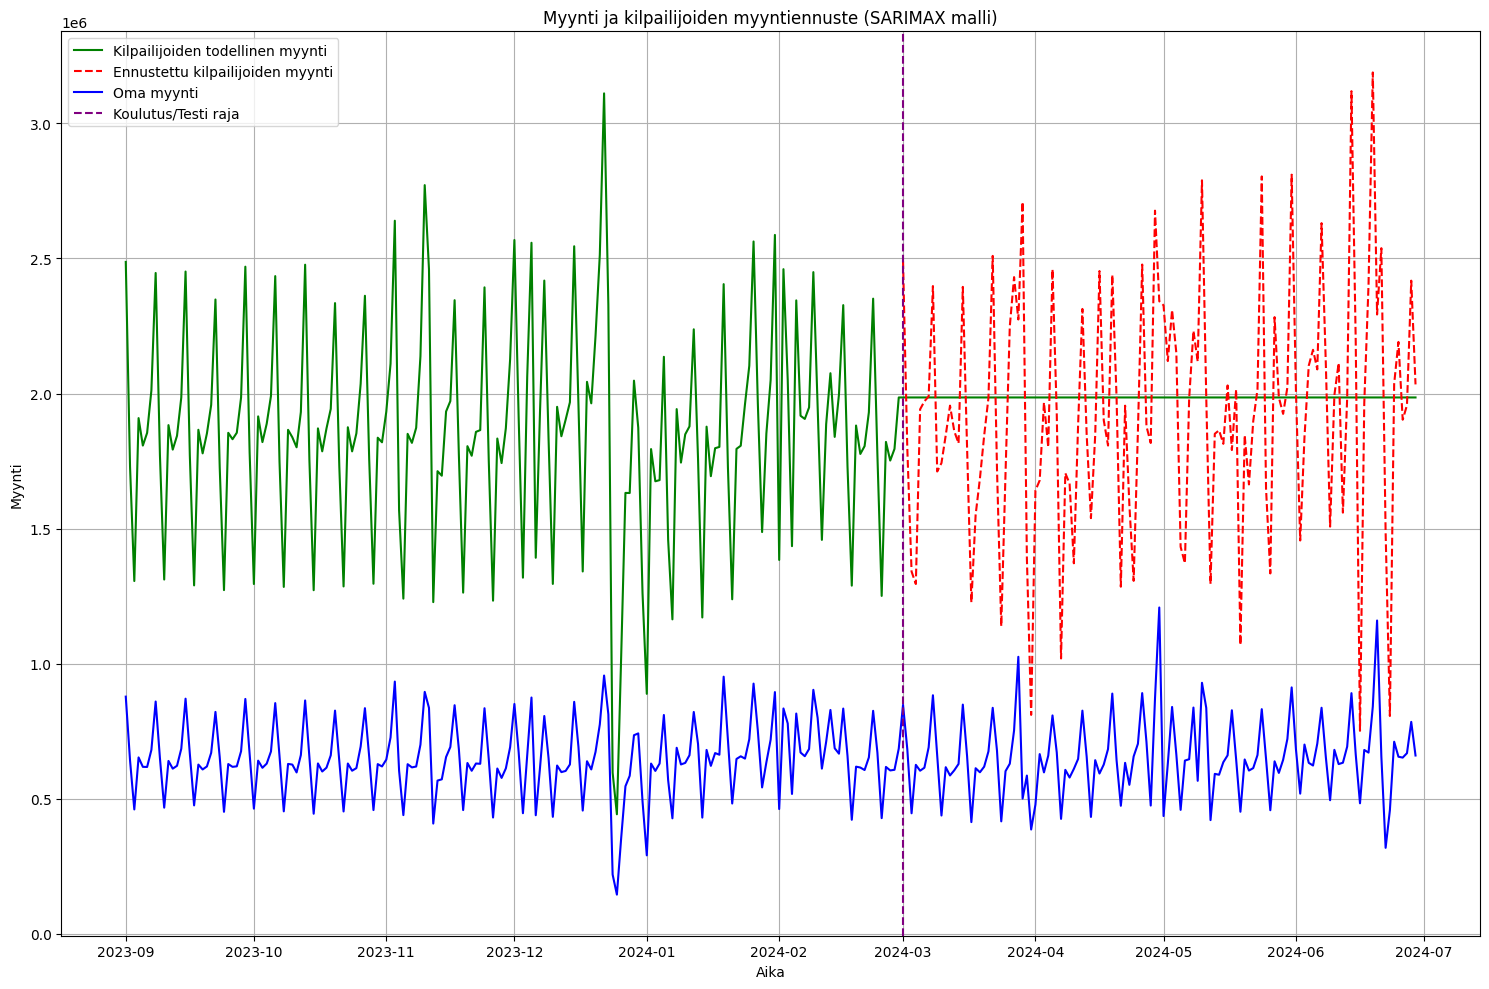

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal

# Oletetaan, että combined_df on jo olemassa ja sisältää 'date', 'amount_own', ja 'amount_comp' sarakkeet

# Datan esikäsittely
df = combined_df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Funktio puuttuvien arvojen käsittelyyn
def handle_missing_data(df):
    # Täytetään puuttuvat arvot lineaarisella interpolaatiolla
    df = df.interpolate(method='time')
    # Jos on vielä NaN-arvoja alussa tai lopussa, täytetään ne lähimmällä ei-NaN arvolla
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

# Funktio trendin erottamiseen
def extract_trend(series, window_length=7):
    # Käytetään Savitzky-Golay-suodatinta trendin erottamiseen
    trend = signal.savgol_filter(series, window_length, 3)
    return pd.Series(trend, index=series.index)

# Käsitellään puuttuvat arvot
df = handle_missing_data(df)

# Erotellaan trendit
df['own_trend'] = extract_trend(df['amount_own'])
df['comp_trend'] = extract_trend(df['amount_comp'])

# Jaetaan data koulutus- ja testisetteihin
train = df[:'2024-02-29']
test = df['2024-03-01':]

# SARIMAX-malli
def fit_sarimax(endog, exog, order=(1,1,1), seasonal_order=(1,1,1,7)):
    model = SARIMAX(endog, exog=exog, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    return results

# Sovitetaan malli
model = fit_sarimax(train['amount_comp'], exog=train[['own_trend']])

# Tehdään ennuste
forecast = model.get_forecast(steps=len(test), exog=test[['own_trend']])
predicted_mean = forecast.predicted_mean

# Lisätään satunnaisuutta ennusteeseen
residuals = model.resid
noise = np.random.choice(residuals, size=len(predicted_mean))
final_forecast = predicted_mean + noise

# Lasketaan RMSE
rmse = sqrt(mean_squared_error(test['amount_comp'], final_forecast))
print(f"RMSE: {rmse}")

# Visualisointi
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['amount_comp'], label='Kilpailijoiden todellinen myynti', color='green')
plt.plot(test.index, final_forecast, label='Ennustettu kilpailijoiden myynti', color='red', linestyle='--')
plt.plot(df.index, df['amount_own'], label='Oma myynti', color='blue')
plt.axvline(x=pd.to_datetime('2024-03-01'), color='purple', linestyle='--', label='Koulutus/Testi raja')

plt.title('Myynti ja kilpailijoiden myyntiennuste (SARIMAX malli)')
plt.xlabel('Aika')
plt.ylabel('Myynti')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()